In [1]:
import sys
import os
import typing as tp

import numpy as np
import scipy
import matplotlib.pyplot as plt

import torch
import math
import torch.nn as nn

In [2]:
sys.path.append(os.path.abspath('D:\ITC\РНФ_Курганский_2024\pythonProject'))
import spin_system
import spectra_manager
import res_field_algorithm
import res_freq_algorithm

from importlib import reload
import constants

reload(res_freq_algorithm)
reload(spectra_manager)
import mesher

In [3]:
import pl_tw_photons
reload(pl_tw_photons)
reload(mesher.delanay_neigbour)
reload(mesher)
reload(res_field_algorithm)
reload(spectra_manager)

<module 'spectra_manager' from 'D:\\ITC\\РНФ_Курганский_2024\\pythonProject\\spectra_manager.py'>

In [4]:
pl_tw_photons.TwWaveAver(helicity=1, theta=10, radius=1, total_momentum=-1)(10)

(tensor(0.0081), tensor(0.0027), tensor(-0.0159))

In [5]:
pl_tw_photons.PlaneWaveTerms(-1, 0.1)(10)

(tensor(0.4975), tensor(0.0050), tensor(-0.9950))

In [6]:
def graph(r, kappas, bessel_idxs):
    out = []
    for kappa in kappas:
        kappa_out = []
        for b_idx in bessel_idxs:
            y = (scipy.special.jv(b_idx, kappa * r)) ** 2
            kappa_out.append({"y": y, "kappa": kappa, "b_idx": b_idx})
        out.append(kappa_out)
    return out

In [7]:
len(out)

NameError: name 'out' is not defined

In [ ]:
r = np.linspace(0, 1.5, 500)
kappas = [70, 10, 1]
bessel_idxs = [0, 1, 2]

out = graph(r, kappas, bessel_idxs)
fig, axes = plt.subplots(ncols=1, nrows=len(kappas), figsize=(8, 10))
for idx, (kappa, kappa_outs) in enumerate(zip(kappas, out)):
    for kappa_out in kappa_outs:
        print(kappa_out["kappa"])
        axes[idx].plot(r, kappa_out["y"], label=f"{kappa_out['b_idx']}")
        axes[idx].legend
plt.savefig("bessels.eps")
plt.show()

In [ ]:
y = scipy.special.jv(0, r) ** 2 - scipy.special.jv(-1, r) * scipy.special.jv(1, r)
plt.plot(r, y)

figure, axes = plt.subplots(3, 1)
for axis, kappa_out in zip(axes, out):
    for bessel in kappa_out:
        kappa = bessel["kappa"]
        b_idx = bessel["b_idx"]
        y = bessel["y"]
        axis.plot(r, y, label=f"b_idx: {b_idx}")
        axis.legend()
plt.savefig("bessel_sq.eps")
plt.show()

mesh = mesher.DelaunayMeshNeighbour(initial_grid_frequency=40, interpolation_grid_frequency=100)
### SpectraCreation

In [ ]:
mesh = mesher.DelaunayMeshNeighbourFullSphere(initial_grid_frequency=60, interpolation_grid_frequency=100)

In [ ]:
s, _ = mesh.post_mesh

In [ ]:
len(s)

### Let's generate spin system

In [12]:
def get_sample_hetero():
    g_interaction_rad = spin_system.Interaction((2.02, 2.02, 2.02))
    g_interaction_co = spin_system.Interaction((2.02, 2.07, 2.30))
    J = constants.unit_converter(-20, "cm-1_to_Hz")
    exchange = spin_system.Interaction((J, J, J))
    
    
    DE_interaction = spin_system.DEInteraction((constants.unit_converter(-15, "cm-1_to_Hz"), constants.unit_converter(-5, "cm-1_to_Hz")))
    base_spin_system = spin_system.SpinSystem(electrons=[1/2, 3/2], g_tensors=[g_interaction_rad, g_interaction_co], electron_electron=[(1, 1, DE_interaction), (0, 1, exchange)])
    mesh = mesher.DelaunayMeshNeighbourFullSphere(initial_grid_frequency=40, interpolation_grid_frequency=100)
    
    sample = spin_system.MultiOrientedSample(spin_system=base_spin_system, ham_strain=1e11, mesh=mesh)
    return sample

def get_sample_DE():
    g_interaction = spin_system.Interaction((2.02, 2.07, 2.25))
    DE_interaction = spin_system.DEInteraction((constants.unit_converter(-30, "cm-1_to_Hz"), constants.unit_converter(-5, "cm-1_to_Hz")))
    base_spin_system = spin_system.SpinSystem(electrons=[3/2], g_tensors=[g_interaction], electron_electron=[(0, 0, DE_interaction)])
    mesh = mesher.DelaunayMeshNeighbourFullSphere(initial_grid_frequency=60, interpolation_grid_frequency=200)
    
    sample = spin_system.MultiOrientedSample(spin_system=base_spin_system, ham_strain=1e11, mesh=mesh)
    return sample

def get_sample_D_plus():
    g_interaction = spin_system.Interaction((2.02, 2.02, 2.02))
    DE_interaction = spin_system.DEInteraction((constants.unit_converter(30.0, "cm-1_to_Hz"), constants.unit_converter(0, "cm-1_to_Hz")))
    base_spin_system = spin_system.SpinSystem(electrons=[3/2], g_tensors=[g_interaction], electron_electron=[(0, 0, DE_interaction)])
    mesh = mesher.DelaunayMeshNeighbourFullSphere(initial_grid_frequency=60, interpolation_grid_frequency=200)
    
    sample = spin_system.MultiOrientedSample(spin_system=base_spin_system, ham_strain=1e11, mesh=mesh)
    return sample

def get_sample_low_D():
    g_interaction = spin_system.Interaction((2.02, 2.02, 2.02))
    DE_interaction = spin_system.DEInteraction((constants.unit_converter(-8, "cm-1_to_Hz"), constants.unit_converter(-2, "cm-1_to_Hz")))
    base_spin_system = spin_system.SpinSystem(electrons=[3/2], g_tensors=[g_interaction], electron_electron=[(0, 0, DE_interaction)])
    mesh = mesher.DelaunayMeshNeighbourFullSphere(initial_grid_frequency=60, interpolation_grid_frequency=200)
    
    sample = spin_system.MultiOrientedSample(spin_system=base_spin_system, ham_strain=1e10, mesh=mesh)
    return sample


def get_sample():
    g_interaction = spin_system.Interaction((2.02, 2.02, 2.02))
    DE_interaction = spin_system.DEInteraction((constants.unit_converter(-30, "cm-1_to_Hz"), constants.unit_converter(0, "cm-1_to_Hz")))
    base_spin_system = spin_system.SpinSystem(electrons=[3/2], g_tensors=[g_interaction], electron_electron=[(0, 0, DE_interaction)])
    mesh = mesher.DelaunayMeshNeighbourFullSphere(initial_grid_frequency=60, interpolation_grid_frequency=200)
    
    sample = spin_system.MultiOrientedSample(spin_system=base_spin_system, ham_strain=1e11, mesh=mesh)
    return sample

In [13]:
constants.unit_converter(1e11, "Hz_to_cm-1")

3.3356409519815204

In [14]:
sample = get_sample()

D:\ITC\РНФ_Курганский_2024\pythonProject\spin_system.py:345: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\Copy.cpp:308.)
  _rot_matrix = self.euler_to_rotmat(_frame).to(self.components.dtype)


In [15]:
F, Gx, Gy, Gz = sample.get_hamiltonian_terms()

In [16]:
H = F + 10 * Gz
u, v = torch.linalg.eigh(H)

u_zeem, v_zeem = torch.linalg.eigh(Gz)

In [17]:
v_zeem[-1, :, 1]

tensor([0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j])

In [18]:
constants.unit_converter(1e11, "Hz_to_cm-1")

3.3356409519815204

In [19]:
["plane", "tw_average", "tw_radius"]

['plane', 'tw_average', 'tw_radius']

In [20]:
theta = 3.0 * math.pi/180

sample = get_sample()

temperature = 300.0
res_field = 10.0
freq = torch.linspace(0, 3000, 1000) * 1e9  

idx = 0

wave_number = constants.unit_converter(freq, "Hz_to_cm-1")


def k_to_kappa(x):
    return math.sin(theta) * x * math.pi * 2

def kappa_to_k(x):
    return  x / (math.sin(theta) * math.pi * 2)

F, Gx, Gy, Gz = sample.get_hamiltonian_terms()
vals, vectors = torch.linalg.eigh(F + 10 * Gz)

tr_freq = (vals[..., None] - vals[..., None, :])
tr_wave = constants.unit_converter(tr_freq, "Hz_to_cm-1")

In [21]:
v_line_1.shape

NameError: name 'v_line_1' is not defined

In [22]:
v_line_1 = tr_wave[..., 3, 2]
v_line_2 = tr_wave[..., 2, 0]
v_line_3 = tr_wave[..., 3, 1]

v_line_4 = tr_wave[..., 3, 0]

In [23]:
v_line_2

tensor([69.4307, 69.4307, 69.4307,  ..., 53.1420, 53.1420, 53.1420])

In [24]:
import seaborn as sns

In [25]:
v_line_3[0]

tensor(50.5693)

In [26]:
torch.mean(v_line_3)

tensor(62.2092)

<AxesSubplot: ylabel='Density'>

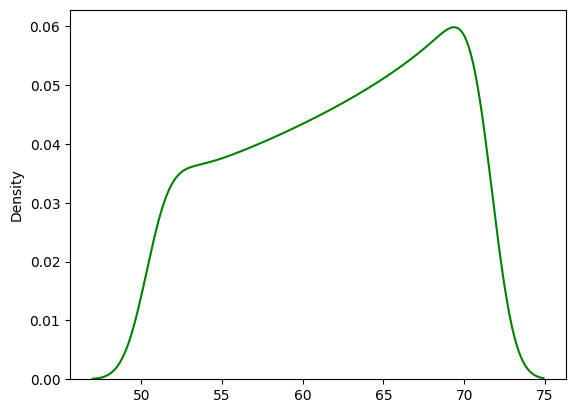

In [27]:
sns.kdeplot(v_line_3, color='green', label='v_line_1')

In [32]:
import pandas as pd

tensor(9.4307)
tensor(69.4307)
tensor(50.5693)


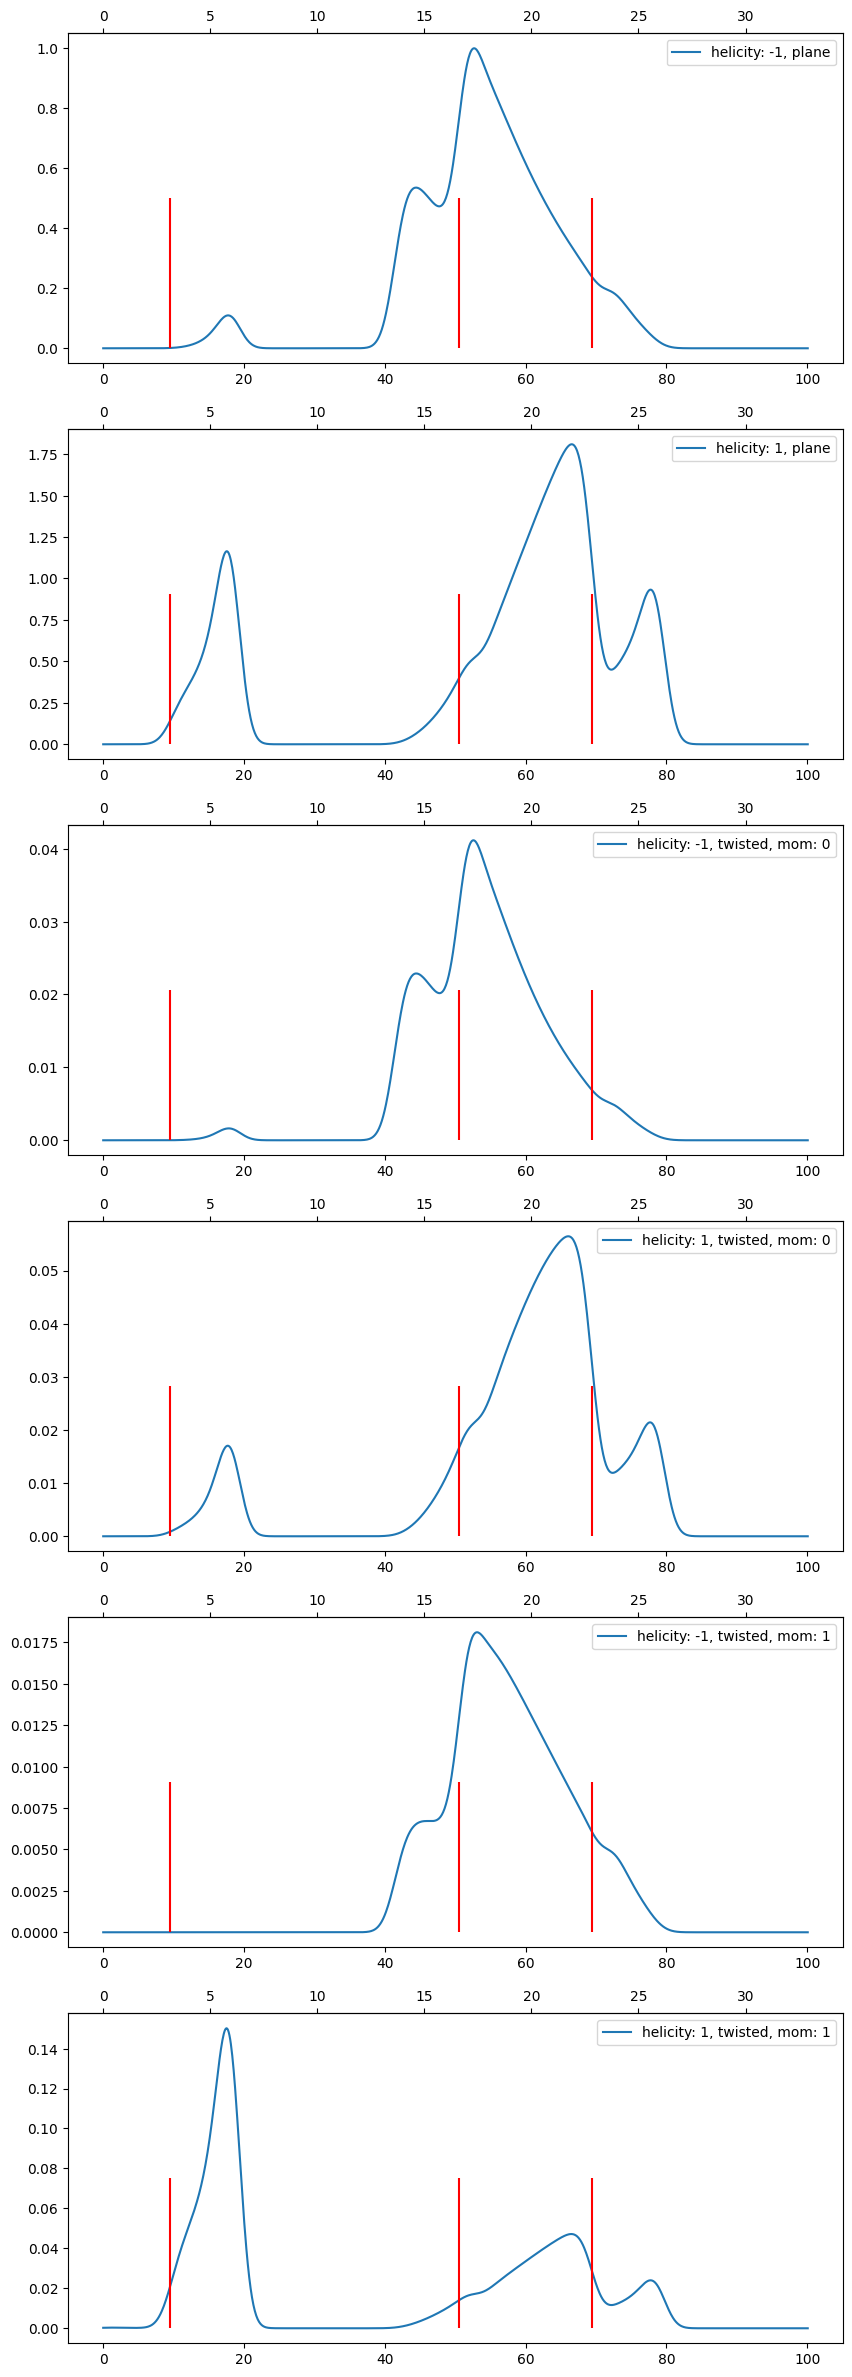

In [41]:
fig, axes = plt.subplots(nrows=6,  figsize=(10, 30))

theta = 3.0 * math.pi/180

sample = get_sample()

temperature = 300.0
res_field = 10.0
freq = torch.linspace(0, 3000, 1000) * 1e9  

idx = 0

wave_number = constants.unit_converter(freq, "Hz_to_cm-1")




def k_to_kappa(x):
    return math.sin(theta) * x * math.pi * 2

def kappa_to_k(x):
    return  x / (math.sin(theta) * math.pi * 2)

F, Gx, Gy, Gz = sample.get_hamiltonian_terms()
vals, vectors = torch.linalg.eigh(F + 10 * Gz)

tr_freq_l = (vals[0][..., None] - vals[0][..., None, :])
tr_wave_l = constants.unit_converter(tr_freq_l, "Hz_to_cm-1")

tr_freq_r = (vals[-1][..., None] - vals[-1][..., None, :])
tr_wave_r = constants.unit_converter(tr_freq_r, "Hz_to_cm-1")

v_line_1_l = tr_wave_l[3, 2]
v_line_2_l = tr_wave_l[2, 0]
v_line_3_l = tr_wave_l[3, 1]

print(v_line_1_l)
print(v_line_2_l)
print(v_line_3_l)

#v_line_1_r = tr_wave_r[3, 2]
#v_line_2_r = tr_wave_r[2, 0]
#v_line_3_r = tr_wave_r[3, 1]
dataframe_dict_point = {"wave_number": wave_number, "kappa": k_to_kappa(wave_number)}

norm_coefficient = 1.0
for helicity in [-1, 1]:
    intensity_calculator = pl_tw_photons.TwPlIntensityCalculator(
        spin_system_dim=sample.base_spin_system.spin_system_dim, radius=1, total_momentum=1, helicity=helicity, theta=theta, compute_type="plane", temperature=temperature)
    with torch.no_grad():
        creator = spectra_manager.StationarySpectraCreatorFreq(field=res_field, sample=sample, harmonic=0, intensity_calculator=intensity_calculator)
        out = creator(sample=sample, freq=freq)
        if idx == 0:
            norm_coefficient = abs(out).max()
        out = out / norm_coefficient
        dataframe_dict_point[f"plane_helicity_{helicity}"] = out.numpy()
        
    axes[idx].plot(wave_number.numpy(), out.numpy(), label=f"helicity: {helicity}, plane")
    secax = axes[idx].secondary_xaxis('top', functions=(k_to_kappa, kappa_to_k))
    axes[idx].legend()
    
    axes[idx].vlines(v_line_1_l, 0.0, out.abs().max() / 2, color="r")
    axes[idx].vlines(v_line_2_l, 0.0, out.abs().max() / 2, color="r")
    axes[idx].vlines(v_line_3_l, 0.0, out.abs().max() / 2, color="r")
    
    #axes[idx].vlines(v_line_1_r, 0.0, out.abs().max() / 2, color="g")
    #axes[idx].vlines(v_line_2_r, 0.0, out.abs().max() / 2, color="g")
    #axes[idx].vlines(v_line_3_r, 0.0, out.abs().max() / 2, color="g")
    idx += 1

    

for total_mom in [0, 1]:
    for helicity in [-1, 1]:
        intensity_calculator = pl_tw_photons.TwPlIntensityCalculator(
            spin_system_dim=sample.base_spin_system.spin_system_dim, radius=1.0, total_momentum=total_mom, helicity=helicity, theta=theta, compute_type="tw_average", temperature=temperature)
        with torch.no_grad():
            creator = spectra_manager.StationarySpectraCreatorFreq(field=res_field, sample=sample, harmonic=0, intensity_calculator=intensity_calculator)
            out = creator(sample=sample, freq=freq) / norm_coefficient
            dataframe_dict_point[f"twisted__helicity_{helicity}_momentum_{total_mom}"] = out.numpy()
            
        axes[idx].plot(wave_number.numpy(), out.numpy(), label=f"helicity: {helicity}, twisted, mom: {total_mom}")
        secax = axes[idx].secondary_xaxis('top', functions=(k_to_kappa, kappa_to_k))
        axes[idx].legend()
        
        axes[idx].vlines(v_line_1_l, 0.0, out.abs().max() / 2, color="r")
        axes[idx].vlines(v_line_2_l, 0.0, out.abs().max() / 2, color="r")
        axes[idx].vlines(v_line_3_l, 0.0, out.abs().max() / 2, color="r")
        
        #axes[idx].vlines(v_line_1_r, 0.0, out.abs().max() / 2, color="g")
        #axes[idx].vlines(v_line_2_r, 0.0, out.abs().max() / 2, color="g")
        #axes[idx].vlines(v_line_3_r, 0.0, out.abs().max() / 2, color="g")
        
        
        idx += 1

In [42]:
dataframe_dict_point.keys()

dict_keys(['wave_number', 'kappa', 'plane_helicity_-1', 'plane_helicity_1', 'twisted__helicity_-1_momentum_0', 'twisted__helicity_1_momentum_0', 'twisted__helicity_-1_momentum_1', 'twisted__helicity_1_momentum_1'])

In [43]:
dataframe_point = pd.DataFrame(dataframe_dict_point)

In [44]:
dataframe_point.to_csv('data_frame_pellet_object_isotropic.csv', index=False)

In [47]:
def get_sample_hetero():
    g_interaction_rad = spin_system.Interaction((2.02, 2.02, 2.02))
    g_interaction_co = spin_system.Interaction((2.02, 2.07, 2.25))
    J = constants.unit_converter(-20, "cm-1_to_Hz")
    exchange = spin_system.Interaction((J, J, J))
    
    
    DE_interaction = spin_system.DEInteraction((constants.unit_converter(-15, "cm-1_to_Hz"), constants.unit_converter(-5, "cm-1_to_Hz")))
    base_spin_system = spin_system.SpinSystem(electrons=[1/2, 3/2], g_tensors=[g_interaction_rad, g_interaction_co], electron_electron=[(1, 1, DE_interaction), (0, 1, exchange)])
    mesh = mesher.DelaunayMeshNeighbourFullSphere(initial_grid_frequency=40, interpolation_grid_frequency=100)
    
    sample = spin_system.MultiOrientedSample(spin_system=base_spin_system, ham_strain=1e11, mesh=mesh)
    return sample

def get_sample_DE():
    g_interaction = spin_system.Interaction((2.02, 2.07, 2.25))
    DE_interaction = spin_system.DEInteraction((constants.unit_converter(-30, "cm-1_to_Hz"), constants.unit_converter(-5, "cm-1_to_Hz")))
    base_spin_system = spin_system.SpinSystem(electrons=[3/2], g_tensors=[g_interaction], electron_electron=[(0, 0, DE_interaction)])
    mesh = mesher.DelaunayMeshNeighbourFullSphere(initial_grid_frequency=60, interpolation_grid_frequency=200)
    
    sample = spin_system.MultiOrientedSample(spin_system=base_spin_system, ham_strain=1e11, mesh=mesh)
    return sample

def get_sample_D_plus():
    g_interaction = spin_system.Interaction((2.02, 2.02, 2.02))
    DE_interaction = spin_system.DEInteraction((constants.unit_converter(30.0, "cm-1_to_Hz"), constants.unit_converter(0, "cm-1_to_Hz")))
    base_spin_system = spin_system.SpinSystem(electrons=[3/2], g_tensors=[g_interaction], electron_electron=[(0, 0, DE_interaction)])
    mesh = mesher.DelaunayMeshNeighbourFullSphere(initial_grid_frequency=60, interpolation_grid_frequency=200)
    
    sample = spin_system.MultiOrientedSample(spin_system=base_spin_system, ham_strain=1e11, mesh=mesh)
    return sample

def get_sample_low_D():
    g_interaction = spin_system.Interaction((2.02, 2.02, 2.02))
    DE_interaction = spin_system.DEInteraction((constants.unit_converter(-8, "cm-1_to_Hz"), constants.unit_converter(-2, "cm-1_to_Hz")))
    base_spin_system = spin_system.SpinSystem(electrons=[3/2], g_tensors=[g_interaction], electron_electron=[(0, 0, DE_interaction)])
    mesh = mesher.DelaunayMeshNeighbourFullSphere(initial_grid_frequency=60, interpolation_grid_frequency=200)
    
    sample = spin_system.MultiOrientedSample(spin_system=base_spin_system, ham_strain=1e10, mesh=mesh)
    return sample

def get_sample():
    g_interaction = spin_system.Interaction((2.02, 2.02, 2.02))
    DE_interaction = spin_system.DEInteraction((constants.unit_converter(-30, "cm-1_to_Hz"), constants.unit_converter(0, "cm-1_to_Hz")))
    base_spin_system = spin_system.SpinSystem(electrons=[3/2], g_tensors=[g_interaction], electron_electron=[(0, 0, DE_interaction)])
    mesh = mesher.DelaunayMeshNeighbourFullSphere(initial_grid_frequency=60, interpolation_grid_frequency=200)
    
    sample = spin_system.MultiOrientedSample(spin_system=base_spin_system, ham_strain=1e11, mesh=mesh)
    return sample### MORE CASES

In [52]:
def get_sample_hetero():
    g_interaction_rad = spin_system.Interaction((2.02, 2.02, 2.02))
    g_interaction_co = spin_system.Interaction((2.02, 2.07, 2.3))
    J = constants.unit_converter(-10, "cm-1_to_Hz")
    exchange = spin_system.Interaction((J, J, J))
    
    
    DE_interaction = spin_system.DEInteraction((constants.unit_converter(-10, "cm-1_to_Hz"), constants.unit_converter(-2, "cm-1_to_Hz")))
    base_spin_system = spin_system.SpinSystem(electrons=[1/2, 3/2], g_tensors=[g_interaction_rad, g_interaction_co], electron_electron=[(1, 1, DE_interaction), (0, 1, exchange)])
    mesh = mesher.DelaunayMeshNeighbourFullSphere(initial_grid_frequency=40, interpolation_grid_frequency=100)
    
    sample = spin_system.MultiOrientedSample(spin_system=base_spin_system, ham_strain=1e11, mesh=mesh)
    return sample

def get_sample_DE():
    g_interaction = spin_system.Interaction((2.02, 2.07, 2.25))
    DE_interaction = spin_system.DEInteraction((constants.unit_converter(-30, "cm-1_to_Hz"), constants.unit_converter(-5, "cm-1_to_Hz")))
    base_spin_system = spin_system.SpinSystem(electrons=[3/2], g_tensors=[g_interaction], electron_electron=[(0, 0, DE_interaction)])
    mesh = mesher.DelaunayMeshNeighbourFullSphere(initial_grid_frequency=60, interpolation_grid_frequency=200)
    
    sample = spin_system.MultiOrientedSample(spin_system=base_spin_system, ham_strain=1e11, mesh=mesh)
    return sample

def get_sample_D_plus():
    g_interaction = spin_system.Interaction((2.02, 2.02, 2.02))
    DE_interaction = spin_system.DEInteraction((constants.unit_converter(30, "cm-1_to_Hz"), constants.unit_converter(0, "cm-1_to_Hz")))
    base_spin_system = spin_system.SpinSystem(electrons=[3/2], g_tensors=[g_interaction], electron_electron=[(0, 0, DE_interaction)])
    mesh = mesher.DelaunayMeshNeighbourFullSphere(initial_grid_frequency=60, interpolation_grid_frequency=200)
    
    sample = spin_system.MultiOrientedSample(spin_system=base_spin_system, ham_strain=1e10, mesh=mesh)
    return sample


def get_sample_low_D():
    g_interaction = spin_system.Interaction((2.02, 2.02, 2.02))
    DE_interaction = spin_system.DEInteraction((constants.unit_converter(30, "cm-1_to_Hz"), constants.unit_converter(0, "cm-1_to_Hz")))
    base_spin_system = spin_system.SpinSystem(electrons=[3/2], g_tensors=[g_interaction], electron_electron=[(0, 0, DE_interaction)])
    mesh = mesher.DelaunayMeshNeighbourFullSphere(initial_grid_frequency=60, interpolation_grid_frequency=200)
    
    sample = spin_system.MultiOrientedSample(spin_system=base_spin_system, ham_strain=1e10, mesh=mesh)
    return sample


def get_sample():
    g_interaction = spin_system.Interaction((2.02, 2.07, 2.3))
    DE_interaction = spin_system.DEInteraction((constants.unit_converter(-30, "cm-1_to_Hz"), constants.unit_converter(-5, "cm-1_to_Hz")))
    base_spin_system = spin_system.SpinSystem(electrons=[3/2], g_tensors=[g_interaction], electron_electron=[(0, 0, DE_interaction)])
    mesh = mesher.DelaunayMeshNeighbourFullSphere(initial_grid_frequency=60, interpolation_grid_frequency=200)
    
    sample = spin_system.MultiOrientedSample(spin_system=base_spin_system, ham_strain=1e11, mesh=mesh)
    return sample

In [56]:
def plot_spectra(axes, theta, sample, temperature, res_field, freq, tw_type):
    idx = 0

    wave_number = constants.unit_converter(freq, "Hz_to_cm-1")
    def k_to_kappa(x):
        return math.sin(theta) * x * math.pi * 2

    def kappa_to_k(x):
        return  x / (math.sin(theta) * math.pi * 2)

    F, Gx, Gy, Gz = sample.get_hamiltonian_terms()
    vals, vectors = torch.linalg.eigh(F + 10 * Gz)

    dataframe_dict = {"wave_number": wave_number, "kappa": k_to_kappa(wave_number)}
    norm_coefficient = 1.0
    for helicity in [-1, 1]:
        intensity_calculator = pl_tw_photons.TwPlIntensityCalculator(
            spin_system_dim=sample.base_spin_system.spin_system_dim, radius=1, total_momentum=1, helicity=helicity, theta=theta, compute_type="plane", temperature=temperature)
        with torch.no_grad():
            creator = spectra_manager.StationarySpectraCreatorFreq(field=res_field, sample=sample, harmonic=0, intensity_calculator=intensity_calculator)
            out = creator(sample=sample, freq=freq)
            if idx == 0:
                norm_coefficient = abs(out).max()
            out = out / norm_coefficient
            dataframe_dict[f"plane_helicity_{helicity}"] = out.numpy()
            
            axes[idx].plot(wave_number.numpy(), out.numpy(), label=f"helicity: {helicity}, plane")
            secax = axes[idx].secondary_xaxis('top', functions=(k_to_kappa, kappa_to_k))
            axes[idx].legend()
        idx += 1

    for total_mom in [0, 1]:
        for helicity in [-1, 1]:
            intensity_calculator = pl_tw_photons.TwPlIntensityCalculator(
                spin_system_dim=sample.base_spin_system.spin_system_dim, radius=1.0, total_momentum=total_mom, helicity=helicity, theta=theta, compute_type=tw_type, temperature=temperature)
            with torch.no_grad():
                creator = spectra_manager.StationarySpectraCreatorFreq(field=res_field, sample=sample, harmonic=0, intensity_calculator=intensity_calculator)
                out = creator(sample=sample, freq=freq) / norm_coefficient
                
                axes[idx].plot(wave_number.numpy(), out.numpy(), label=f"helicity: {helicity}, twisted, mom: {total_mom}")
                secax = axes[idx].secondary_xaxis('top', functions=(k_to_kappa, kappa_to_k))
                axes[idx].legend()
                dataframe_dict[f"twisted__helicity_{helicity}_momentum_{total_mom}"] = out.numpy()
            idx += 1
    return dataframe_dict
    

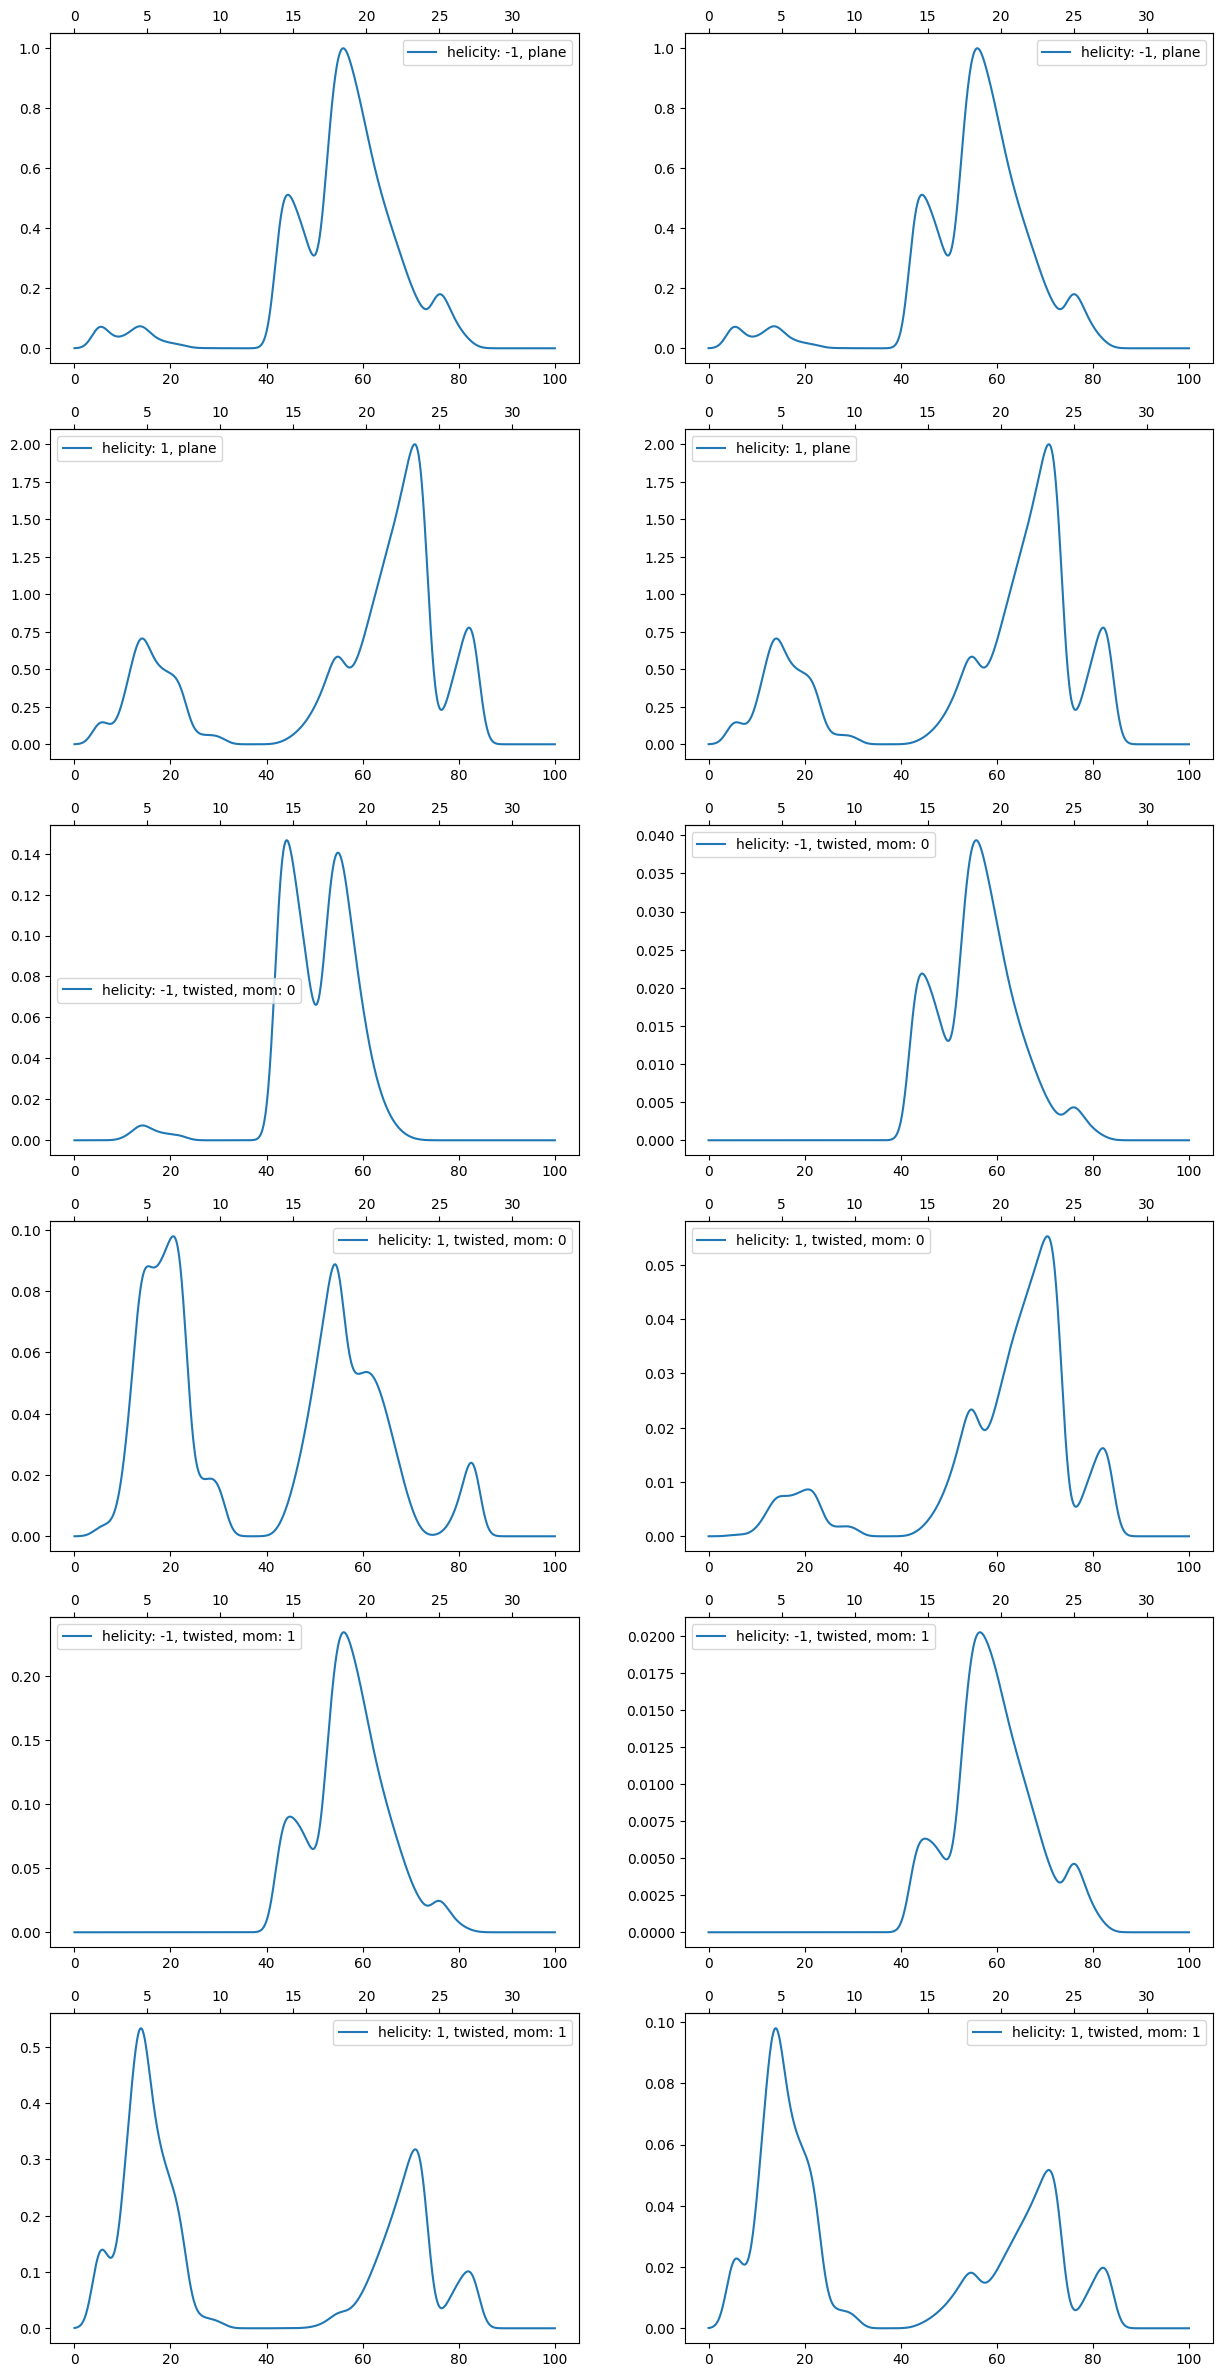

In [58]:
## --30, -5, 300K

fig, axes = plt.subplots(nrows=6, ncols=2,  figsize=(15, 30))

theta = 3.0 * math.pi/180
sample = get_sample()
temperature = 300.0
res_field = 10.0
freq = torch.linspace(0, 3000, 1000) * 1e9  

dataframe_dict_point = plot_spectra(axes[:, 0], theta, sample, temperature, res_field, freq, tw_type="tw_radius")
dataframe_dict_pellet = plot_spectra(axes[:, 1], theta, sample, temperature, res_field, freq, tw_type="tw_average")
plt.savefig("D_E_main_anisotropy")
dataframe_point = pd.DataFrame(dataframe_dict_point)
dataframe_pellet = pd.DataFrame(dataframe_dict_pellet)
dataframe_point.to_csv('data_frame_point_object_heterospin.csv', index=False)
dataframe_pellet.to_csv('data_frame_pellet_object_heterospin.csv', index=False)

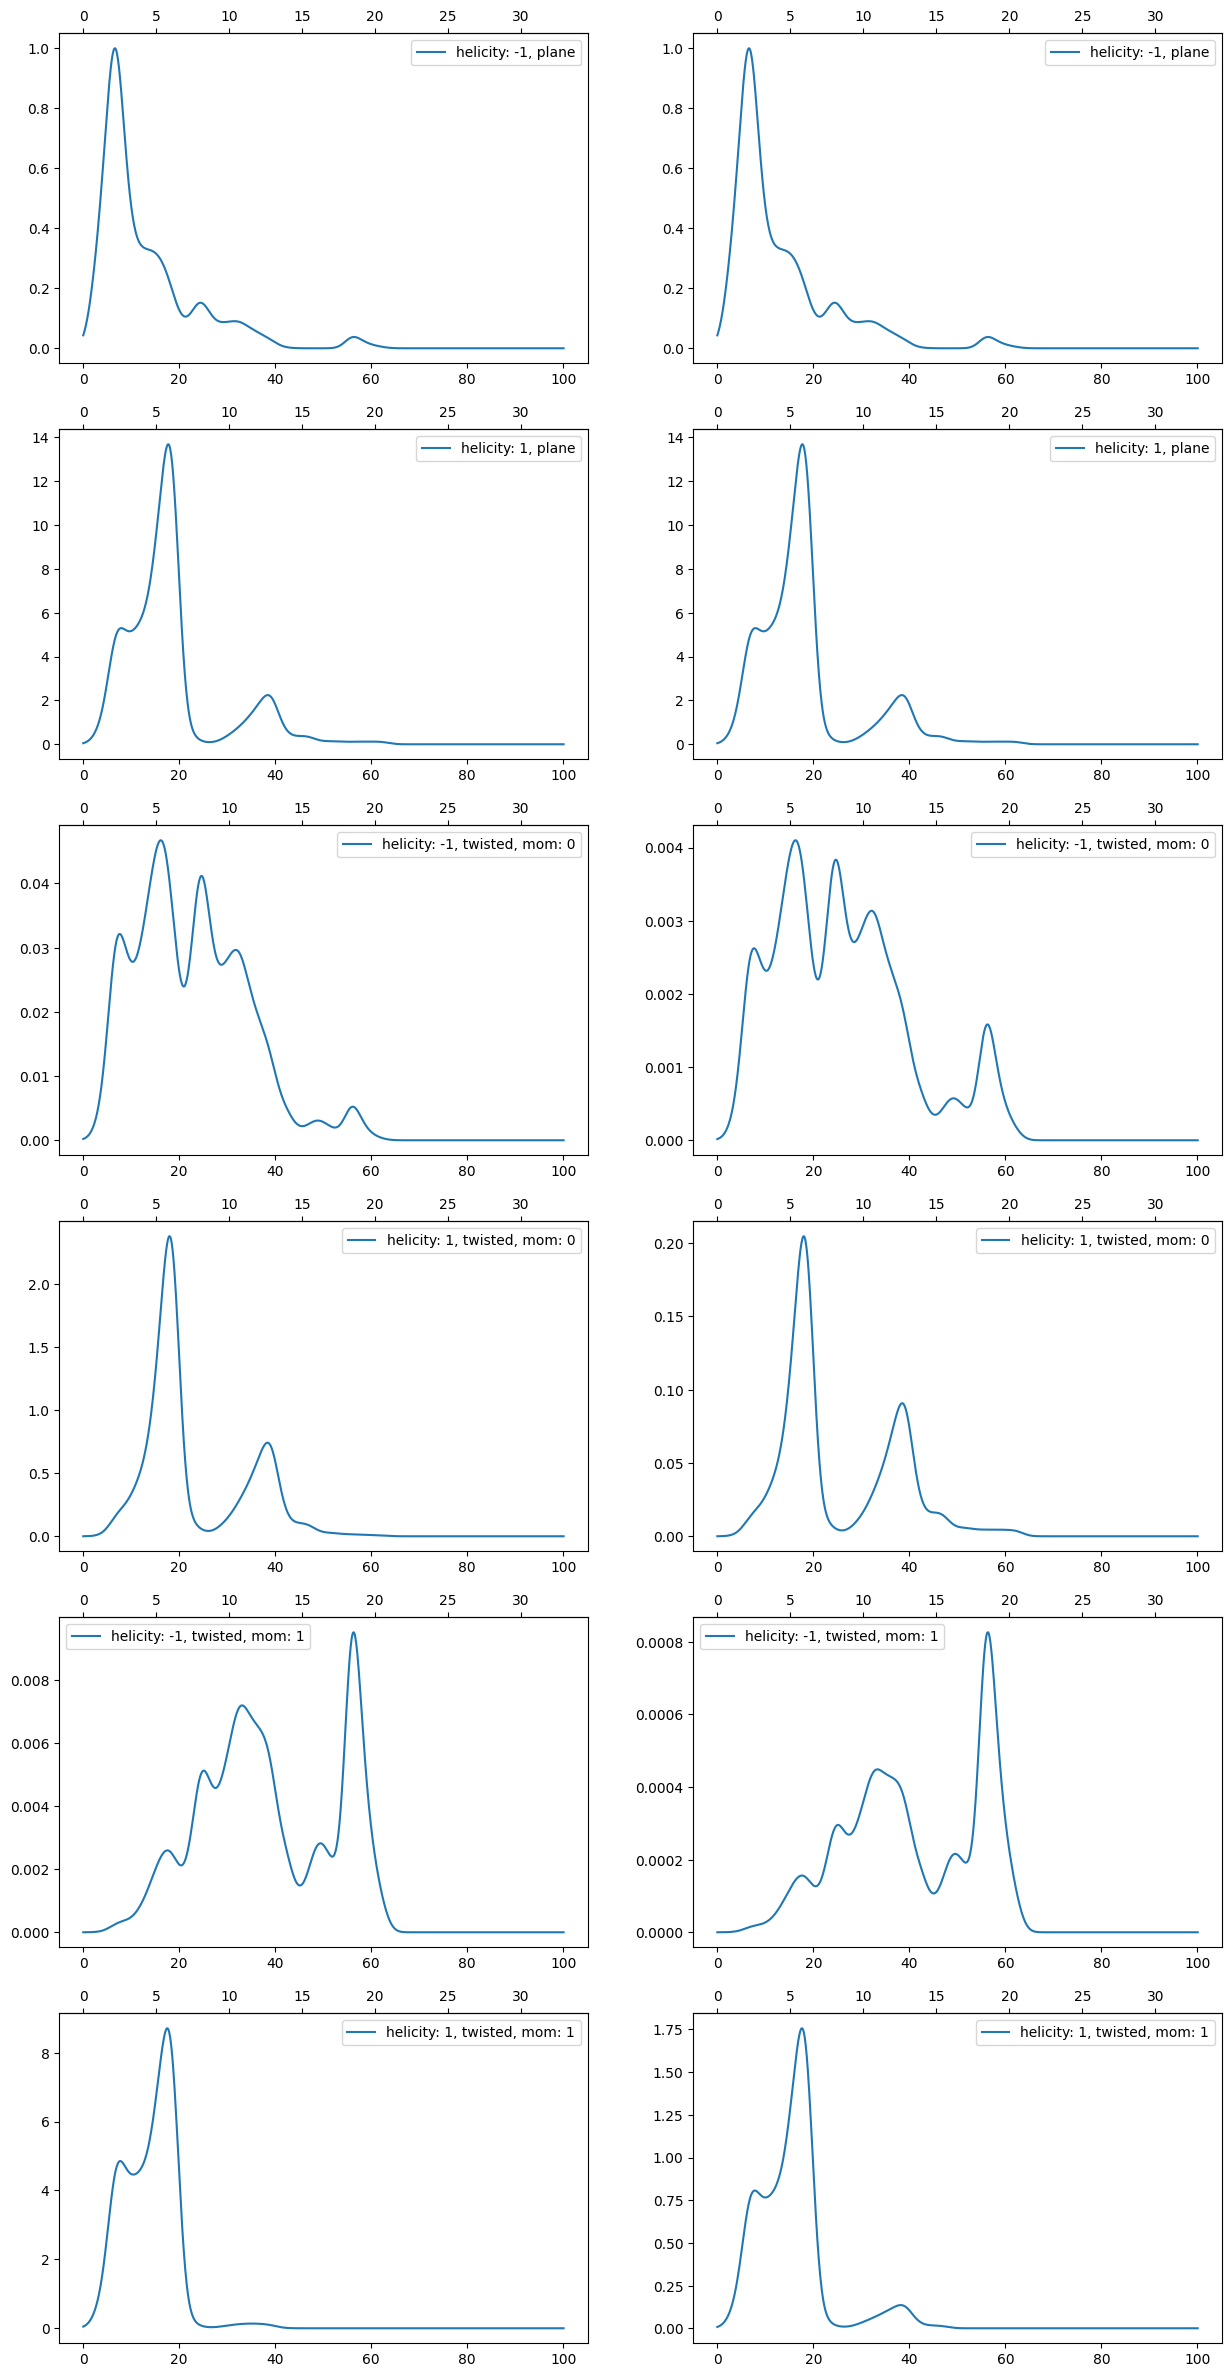

In [14]:
fig, axes = plt.subplots(nrows=6, ncols=2,  figsize=(15, 30))

theta = 3.0 * math.pi/180
sample = get_sample_hetero()
temperature = 5.0
res_field = 10.0
freq = torch.linspace(0, 3000, 1000) * 1e9  

dataframe_dict_point = plot_spectra(axes[:, 0], theta, sample, temperature, res_field, freq, tw_type="tw_radius")
dataframe_dict_pellet = plot_spectra(axes[:, 1], theta, sample, temperature, res_field, freq, tw_type="tw_average")

dataframe_point = pd.DataFrame(dataframe_dict_point)
dataframe_pellet = pd.DataFrame(dataframe_dict_pellet)
dataframe_point.to_csv('data_frame_point_object_DE_anisotropy.csv', index=False)
dataframe_pellet.to_csv('data_frame_pellet_object_DE_anisotropy.csv', index=False)
plt.show()